<a href="https://colab.research.google.com/github/TwistedMat/MNIST-handwritingclassification/blob/main/MNIST_handwritingclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MNIST Handwriting Classification**

Author: Eshan Mehrotra

In [27]:
import numpy as np
import pandas as pd
import gzip
import matplotlib.pyplot as plt

## Reading the Train Image Files

In [28]:
f = gzip.open('/content/sample_data/mnist/train-images-idx3-ubyte.gz','r')
## 16 byte header
f.read(16)
num_images = 60000
image_size = 28  ## Each image is 28x28

In [29]:
buf = f.read(image_size * image_size * num_images)
X_train = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
X_train = X_train.reshape(num_images, image_size * image_size)
X_train.shape

(60000, 784)

## View an image

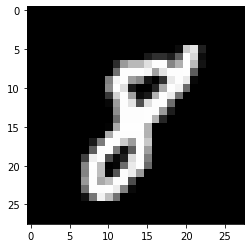

In [30]:
import cv2

img = X_train[17].reshape(28, 28, 1)
resized = cv2.resize(img, (28, 28))
plt.imshow(resized, cmap=plt.get_cmap('gray'))

## Distribution of a pixel

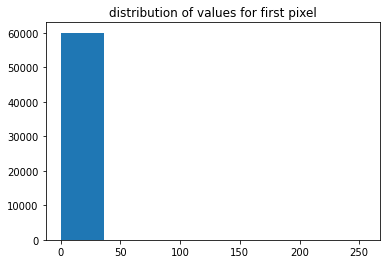

In [31]:
high_med = -1
high_i = -1
for i in range(0,X_train.shape[1]):
    arr = np.histogram(X_train[:,i], bins = np.linspace(0, 255, 8))
    med = np.median(arr[0])
    if med > high_med:
        high_med = med
        high_i = i

        
plt.hist(X_train[:,0], bins = np.linspace(0, 255, 8)) 
plt.title("distribution of values for first pixel") 
plt.show()

High median = 3146, index = 407


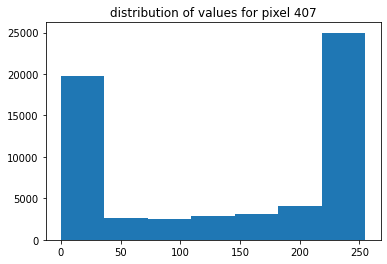

In [32]:
print('High median = %i, index = %i' % (high_med, high_i))
plt.hist(X_train[:,high_i], bins = np.linspace(0, 255, 8)) 
plt.title("distribution of values for pixel 407") 
plt.show()

## Reading the Training Labels

In [33]:
f = gzip.open('/content/sample_data/mnist/train-labels-idx1-ubyte.gz','r')
## 8 byte header
f.read(8)
num_images = 60000
buf = f.read(num_images*1)
y_train = np.frombuffer(buf, dtype=np.uint8)
y_train = y_train.reshape(num_images)
y_train.shape

(60000,)

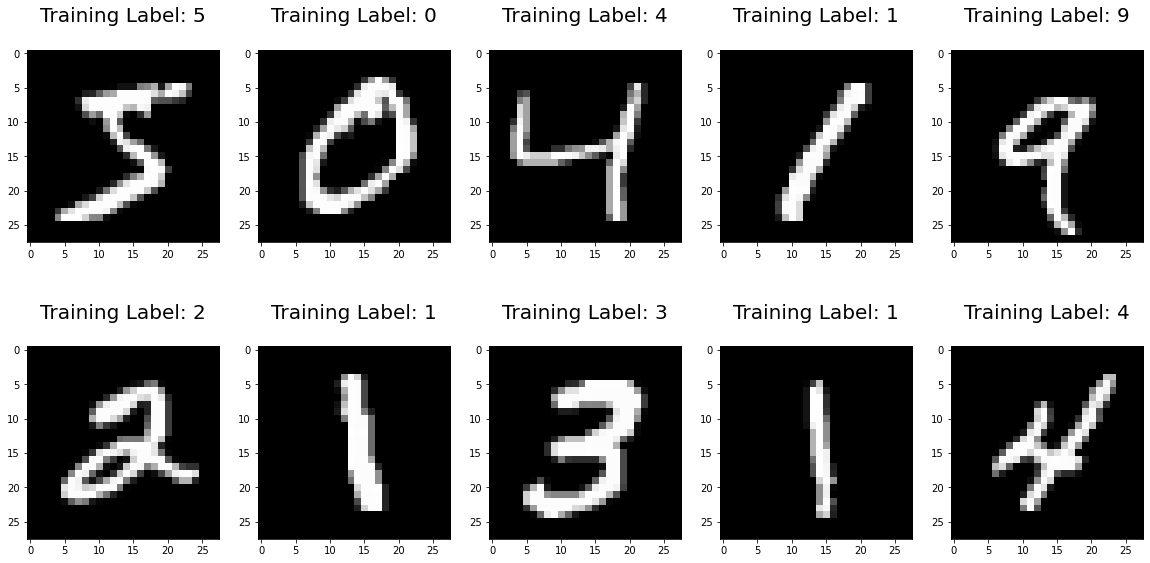

In [34]:
plt.figure(figsize=(20,10))
for index, (image, label) in enumerate(zip(X_train[0:10], y_train[0:10])):
  plt.subplot(2, 5, index + 1)
  plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
  plt.title('Training Label: %i\n' % label, fontsize = 20)

## Logistic Regression Classification

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [ ]:
lr = LogisticRegression(max_iter=1000,solver="lbfgs")
clf_lr = lr.fit(X_train, y_train)
y_pred = clf_lr.predict(X_train)
print('AUC: %0.5f' % accuracy_score(y_train, y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


AUC: 0.94145


## Using SAGA as it theoritically best for Sparse Multinomial Logistic Regression

In [43]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X=X_train)

In [37]:
# %timeit
lr = LogisticRegression(max_iter=500,solver="saga",multi_class="multinomial",n_jobs=-1,tol=0.001)
clf_lr = lr.fit(X_train_scaled, y_train)
y_pred = clf_lr.predict(X_train_scaled)
print('AUC: %0.5f' % accuracy_score(y_train, y_pred))

AUC: 0.93052


In [51]:
import pickle

In [54]:
pickle.dump(clf_lr,open('/content/lr_model.model','wb'))

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'solver': ["saga"], 'penalty': ["l2","elasticnet"],
      'tol':[0.001,0.01],'class_weight':[None,"balanced"]}
  ]

lrig = LogisticRegression(max_iter=100,multi_class="multinomial",n_jobs=-1)

grid_search = GridSearchCV(lrig, param_grid, cv=5,
                           scoring='accuracy',
                           return_train_score=True)
grid_search.fit(X_train_scaled, y_train)

In [58]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

mnb = MultinomialNB()
clf_mnb = mnb.fit(X_train, y_train)
y_pred = clf_mnb.predict(X_train)
print('AUC: %0.5f' % accuracy_score(y_train, y_pred))

AUC: 0.82528


In [39]:
clf_lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'multinomial',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'saga',
 'tol': 0.001,
 'verbose': 0,
 'warm_start': False}

## Loading Test Data

In [40]:
f = gzip.open('/content/sample_data/mnist/t10k-images-idx3-ubyte.gz','r') 
## 16 byte header
f.read(16)
num_images = 10000
image_size = 28  ## Each image is 28x28
buf = f.read(image_size * image_size * num_images)
X_test = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
X_test = X_test.reshape(num_images, image_size * image_size)
X_test.shape


(10000, 784)

In [41]:
f = gzip.open('/content/sample_data/mnist/t10k-labels-idx1-ubyte.gz','r')
## 8 byte header
f.read(8)
num_images = 10000
buf = f.read(num_images*1)
y_test = np.frombuffer(buf, dtype=np.uint8)
y_test = y_test.reshape(num_images)
y_test.shape

(10000,)

## LR Model Evaluaiton on Test Data

In [80]:
X_test_scaled = ss.transform(X=X_test)

In [81]:
y_pred = clf_lr.predict(X_test_scaled)
print('AUC: %0.5f' % accuracy_score(y_test, y_pred))

AUC: 0.92440


In [82]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[ 961    0    0    1    2    5    7    3    1    0]
 [   0 1106    2    2    1    1    4    2   17    0]
 [   8    8  923   17    9    3   13   10   36    5]
 [   4    1   19  918    2   27    2   12   18    7]
 [   1    4    3    2  921    0   12    3    8   28]
 [   7    4    1   34    8  775   19   11   29    4]
 [  10    4    6    1    7   13  912    2    3    0]
 [   2    9   20    6    6    0    0  951    2   32]
 [   7   12    7   18   11   23   10   14  862   10]
 [  10    8    1   11   29    5    0   24    6  915]]


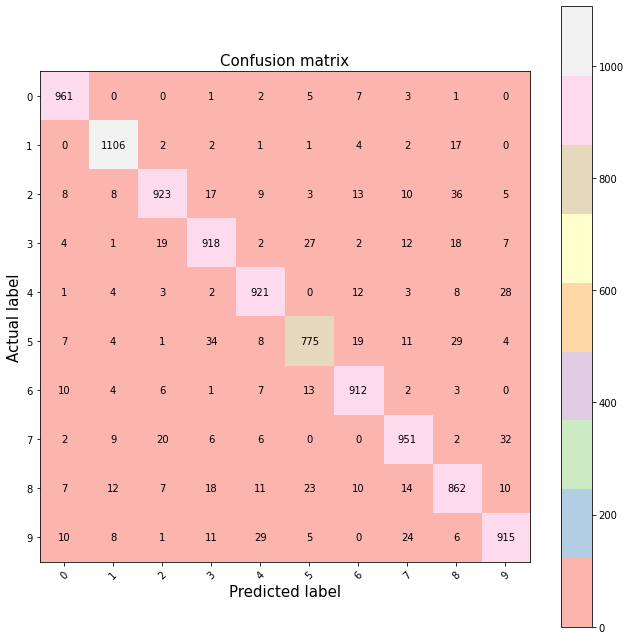

In [83]:
ticks = [str(i) for i in range(0,10)]
plt.figure(figsize=(9,9))
plt.imshow(cm, interpolation='nearest', cmap='Pastel1')
plt.title('Confusion matrix', size = 15)
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, ticks, rotation=45, size = 10)
plt.yticks(tick_marks, ticks, size = 10)
plt.tight_layout()
plt.ylabel('Actual label', size = 15)
plt.xlabel('Predicted label', size = 15)
width, height = cm.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(cm[x][y]), xy=(y, x), 
                     horizontalalignment='center',
                     verticalalignment='center')

In [84]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=ticks))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.97      0.97      1135
           2       0.94      0.89      0.92      1032
           3       0.91      0.91      0.91      1010
           4       0.92      0.94      0.93       982
           5       0.91      0.87      0.89       892
           6       0.93      0.95      0.94       958
           7       0.92      0.93      0.92      1028
           8       0.88      0.89      0.88       974
           9       0.91      0.91      0.91      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [106]:
misclassifiedIndexes = [index for index,(label,predict) in enumerate(zip(y_test, y_pred)) if label!=predict]
len(misclassifiedIndexes)

756

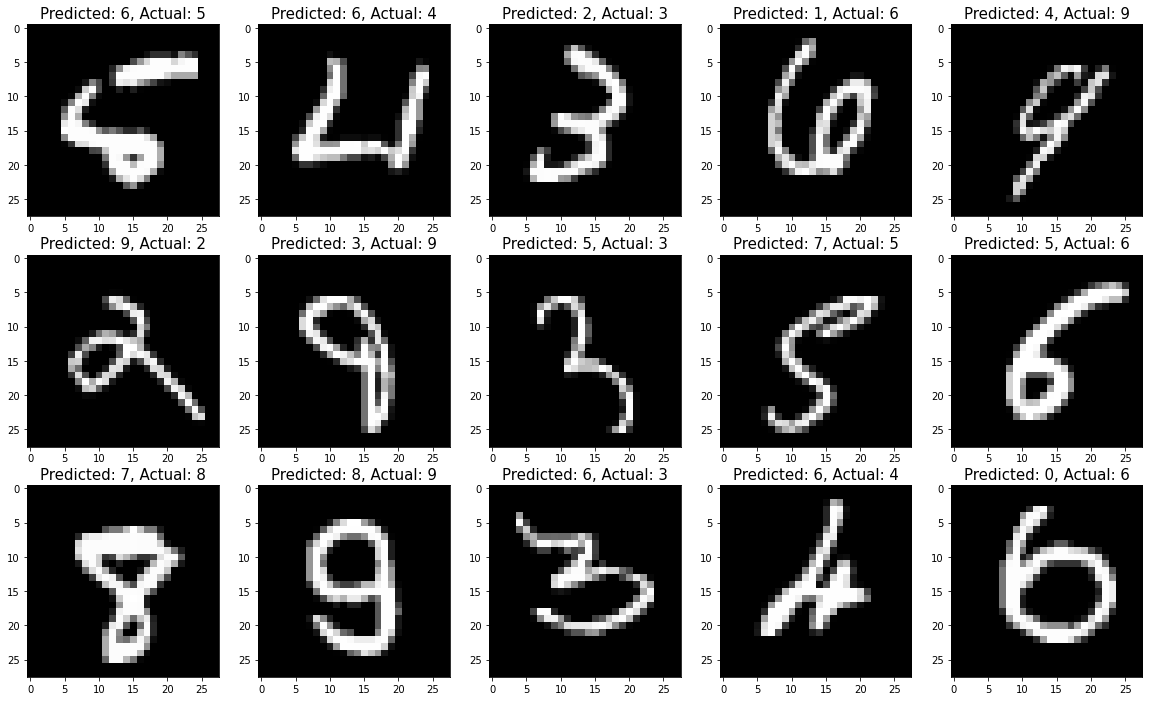

In [105]:
plt.figure(figsize=(20,12))
for plotIndex, badIndex in enumerate(misclassifiedIndexes[0:15]):
 plt.subplot(3, 5, plotIndex + 1)
 plt.imshow(np.reshape(X_test[badIndex], (28,28)), cmap=plt.cm.gray)
 plt.title('Predicted: {}, Actual: {}'.format(y_pred[badIndex], y_test[badIndex]), fontsize = 15)

## Naive-Bayes Model Evaluation on Test Data

In [107]:
y_pred = clf_mnb.predict(X_test)
print('AUC: %0.5f' % accuracy_score(y_test, y_pred))

AUC: 0.83650


In [108]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

[[ 912    0    2    6    1    8   14    1   36    0]
 [   0 1061    5    9    0    2    6    0   51    1]
 [  15   11  858   24   10    3   33   11   66    1]
 [   4   11   34  851    1   21    7   14   40   27]
 [   2    2    6    0  732    0   25    1   38  176]
 [  23   11    6  107   18  590   17    6   78   36]
 [  17   13   17    1    7   25  860    0   18    0]
 [   1   21   11    5   19    0    1  861   40   69]
 [   6   26   13   54   14   27    8    9  777   40]
 [   6    7    3   10   66   10    0   17   27  863]]


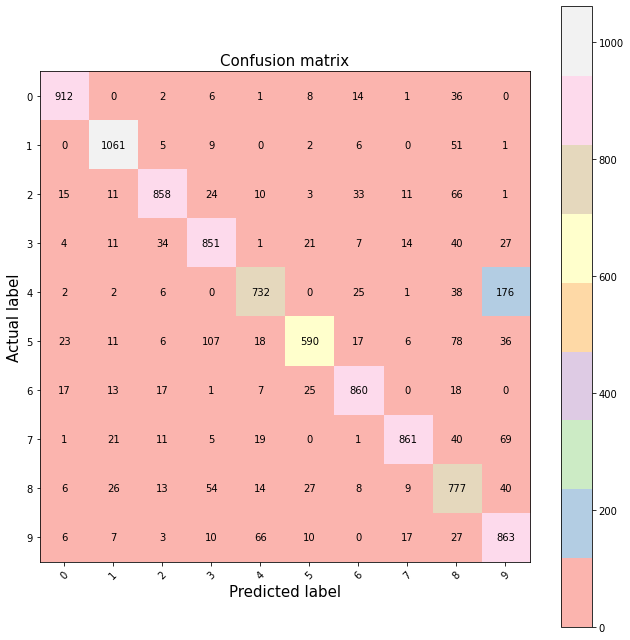

In [109]:
ticks = [str(i) for i in range(0,10)]
plt.figure(figsize=(9,9))
plt.imshow(cm, interpolation='nearest', cmap='Pastel1')
plt.title('Confusion matrix', size = 15)
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, ticks, rotation=45, size = 10)
plt.yticks(tick_marks, ticks, size = 10)
plt.tight_layout()
plt.ylabel('Actual label', size = 15)
plt.xlabel('Predicted label', size = 15)
width, height = cm.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(cm[x][y]), xy=(y, x), 
                     horizontalalignment='center',
                     verticalalignment='center')

In [110]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=ticks))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       980
           1       0.91      0.93      0.92      1135
           2       0.90      0.83      0.86      1032
           3       0.80      0.84      0.82      1010
           4       0.84      0.75      0.79       982
           5       0.86      0.66      0.75       892
           6       0.89      0.90      0.89       958
           7       0.94      0.84      0.88      1028
           8       0.66      0.80      0.72       974
           9       0.71      0.86      0.78      1009

    accuracy                           0.84     10000
   macro avg       0.84      0.83      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [111]:
misclassifiedIndexes = [index for index,(label,predict) in enumerate(zip(y_test, y_pred)) if label!=predict]
len(misclassifiedIndexes)

1635

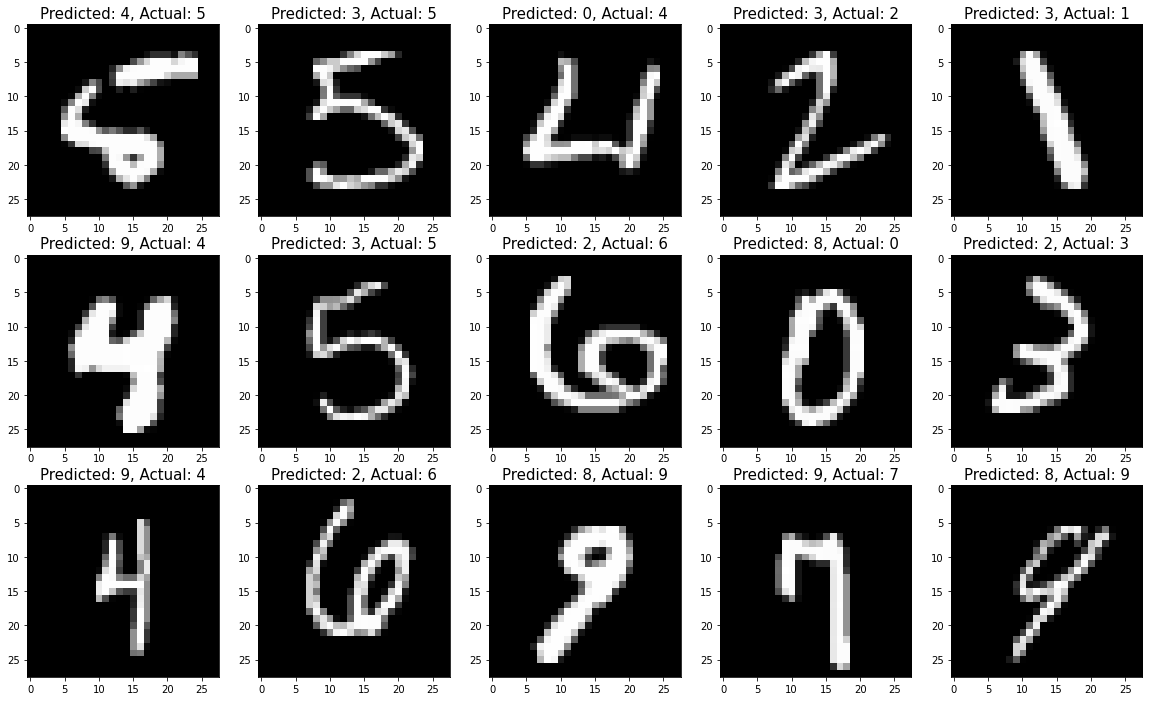

In [112]:
plt.figure(figsize=(20,12))
for plotIndex, badIndex in enumerate(misclassifiedIndexes[0:15]):
 plt.subplot(3, 5, plotIndex + 1)
 plt.imshow(np.reshape(X_test[badIndex], (28,28)), cmap=plt.cm.gray)
 plt.title('Predicted: {}, Actual: {}'.format(y_pred[badIndex], y_test[badIndex]), fontsize = 15)